In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package punkt to /home/boy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/boy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/boy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/boy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2024-03-23 22:05:33.192153: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 22:05:33.195504: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 22:05:33.243891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the followi

In [2]:

# Load dataset
data = pd.read_csv('PSL04_tweets.csv')

In [3]:

# Data Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    clean_text = ' '.join(tokens)
    return clean_text


In [4]:

# Cleaning the reviews
data['clean_text'] = data['Text'].apply(preprocess_text)


In [5]:

# Labeling using TextBlob
def textblob_sentiment_analysis(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'


In [6]:

# Assigning labels
data['sentiment'] = data['clean_text'].apply(textblob_sentiment_analysis)


In [7]:

# Feature Extraction (TF-IDF Vectorization)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(data['clean_text'])
y = data['sentiment']


In [8]:

# Model Evaluation
print("TextBlob Sentiment Analysis Report:")
print(classification_report(data['sentiment'], data['sentiment']))


TextBlob Sentiment Analysis Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2928
     neutral       1.00      1.00      1.00     22467
    positive       1.00      1.00      1.00     15079

    accuracy                           1.00     40474
   macro avg       1.00      1.00      1.00     40474
weighted avg       1.00      1.00      1.00     40474



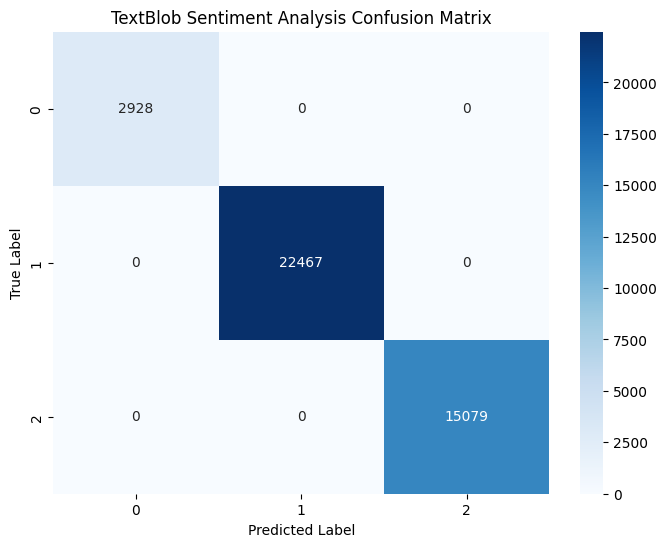

In [9]:

# Visualization (Confusion Matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(data['sentiment'], data['sentiment']), annot=True, fmt="d", cmap="Blues")
plt.title("TextBlob Sentiment Analysis Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## VADER

In [10]:
vader_analyzer = SentimentIntensityAnalyzer()
for text in data['clean_text']:
    vader_analyzer.lexicon.update({word: TextBlob(text).sentiment.polarity for word in text.split()})

def vader_sentiment_analysis(text):
    scores = vader_analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [11]:
# VADER Evaluation
data['vader_prediction'] = data['Text'].apply(vader_sentiment_analysis)
print("VADER Sentiment Analysis Report:")
print(classification_report(data['sentiment'], data['vader_prediction']))

VADER Sentiment Analysis Report:
              precision    recall  f1-score   support

    negative       0.19      0.25      0.21      2928
     neutral       0.90      0.36      0.52     22467
    positive       0.51      0.93      0.66     15079

    accuracy                           0.56     40474
   macro avg       0.53      0.51      0.46     40474
weighted avg       0.70      0.56      0.55     40474



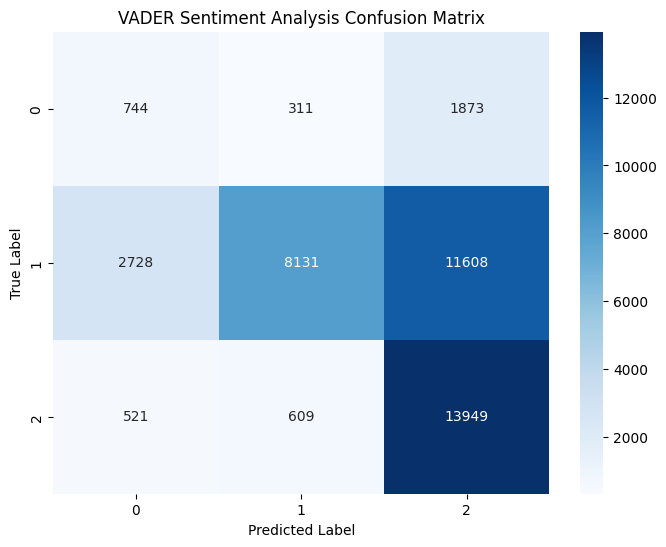

In [12]:
# Confusion Matrix for VADER
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(data['sentiment'], data['vader_prediction']), annot=True, fmt="d", cmap="Blues")
plt.title("VADER Sentiment Analysis Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [13]:
# Split dataset into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [14]:

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [15]:
# Tokenize and encode the training data
train_encodings = tokenizer(train_data['clean_text'].tolist(), truncation=True, padding=True, max_length=128)
train_labels = train_data['sentiment']

In [ ]:

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training data
train_encodings = tokenizer(train_data['clean_text'].tolist(), truncation=True, padding=True, max_length=128)
train_labels = train_data['sentiment']

# Convert sentiment labels to numerical format
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

In [ ]:

# Define BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [ ]:

# Train the model
history = model.fit(train_encodings, train_labels, epochs=3, batch_size=32, validation_split=0.2)


In [ ]:
# Convert test encodings and labels to a dataset
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(32)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
# Make predictions on test data
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1)

253/253 [==============================] - 3873s 15s/step


In [ ]:

# Classification report
print("BERT Sentiment Analysis Report:")
print(classification_report(test_labels, predicted_labels))


BERT Sentiment Analysis Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       563
           1       0.55      1.00      0.71      4461
           2       0.00      0.00      0.00      3071

    accuracy                           0.55      8095
   macro avg       0.18      0.33      0.24      8095
weighted avg       0.30      0.55      0.39      8095



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


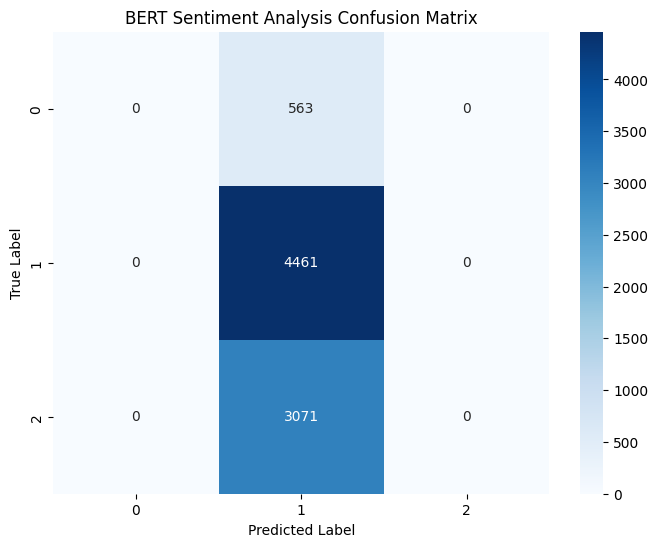

In [ ]:

# Visualization (Confusion Matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_labels, predicted_labels), annot=True, fmt="d", cmap="Blues")
plt.title("BERT Sentiment Analysis Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Save the model
model.save_pretrained('bert_sentiment_analysis_model')

In [ ]:
# Split dataset into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Text'])
train_sequences = tokenizer.texts_to_sequences(train_data['Text'])
test_sequences = tokenizer.texts_to_sequences(test_data['Text'])


In [ ]:


# Pad sequences to ensure uniform length
max_len = max([len(seq) for seq in train_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')


In [ ]:

# Convert sentiment labels to numerical format
label_to_index = {'positive': 0, 'negative': 1, 'neutral': 2}
train_labels = train_data['sentiment'].map(label_to_index)
test_labels = test_data['sentiment'].map(label_to_index)


In [ ]:

# Define LSTM model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len),
    LSTM(64),
    Dense(3, activation='softmax')
])


In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model
history = model.fit(train_sequences, train_labels, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
810/810 [==============================] - 154s 190ms/step - loss: 0.8877 - accuracy: 0.5567 - val_loss: 0.8916 - val_accuracy: 0.5536
Epoch 2/5
810/810 [==============================] - 158s 195ms/step - loss: 0.8859 - accuracy: 0.5567 - val_loss: 0.8895 - val_accuracy: 0.5536
Epoch 3/5
810/810 [==============================] - 150s 185ms/step - loss: 0.8855 - accuracy: 0.5567 - val_loss: 0.8897 - val_accuracy: 0.5536
Epoch 4/5
810/810 [==============================] - 159s 196ms/step - loss: 0.8855 - accuracy: 0.5567 - val_loss: 0.8886 - val_accuracy: 0.5536
Epoch 5/5
810/810 [==============================] - 166s 205ms/step - loss: 0.8851 - accuracy: 0.5567 - val_loss: 0.8891 - val_accuracy: 0.5536


In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


253/253 [==============================] - 7s 28ms/step - loss: 0.8827 - accuracy: 0.5511
Test Loss: 0.8827455639839172, Test Accuracy: 0.5510809421539307


In [ ]:
# Make predictions on test data
predictions = model.predict(test_sequences)
predicted_labels = tf.argmax(predictions, axis=1)


253/253 [==============================] - 8s 32ms/step


In [ ]:

# Classification report
print("LSTM Sentiment Analysis Report:")
print(classification_report(test_labels, predicted_labels))


LSTM Sentiment Analysis Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3071
           1       0.00      0.00      0.00       563
           2       0.55      1.00      0.71      4461

    accuracy                           0.55      8095
   macro avg       0.18      0.33      0.24      8095
weighted avg       0.30      0.55      0.39      8095



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


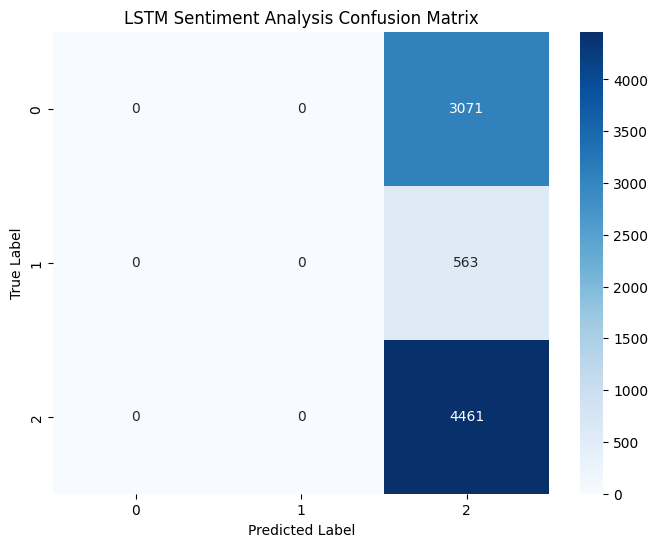

In [ ]:

# Visualization (Confusion Matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_labels, predicted_labels), annot=True, fmt="d", cmap="Blues")
plt.title("LSTM Sentiment Analysis Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Save the model
model.save("lstm_sentiment_analysis_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import joblib

# Save VADER model
joblib.dump(vader_analyzer, 'vader_model.pkl')